# DT2470 Lab 03: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

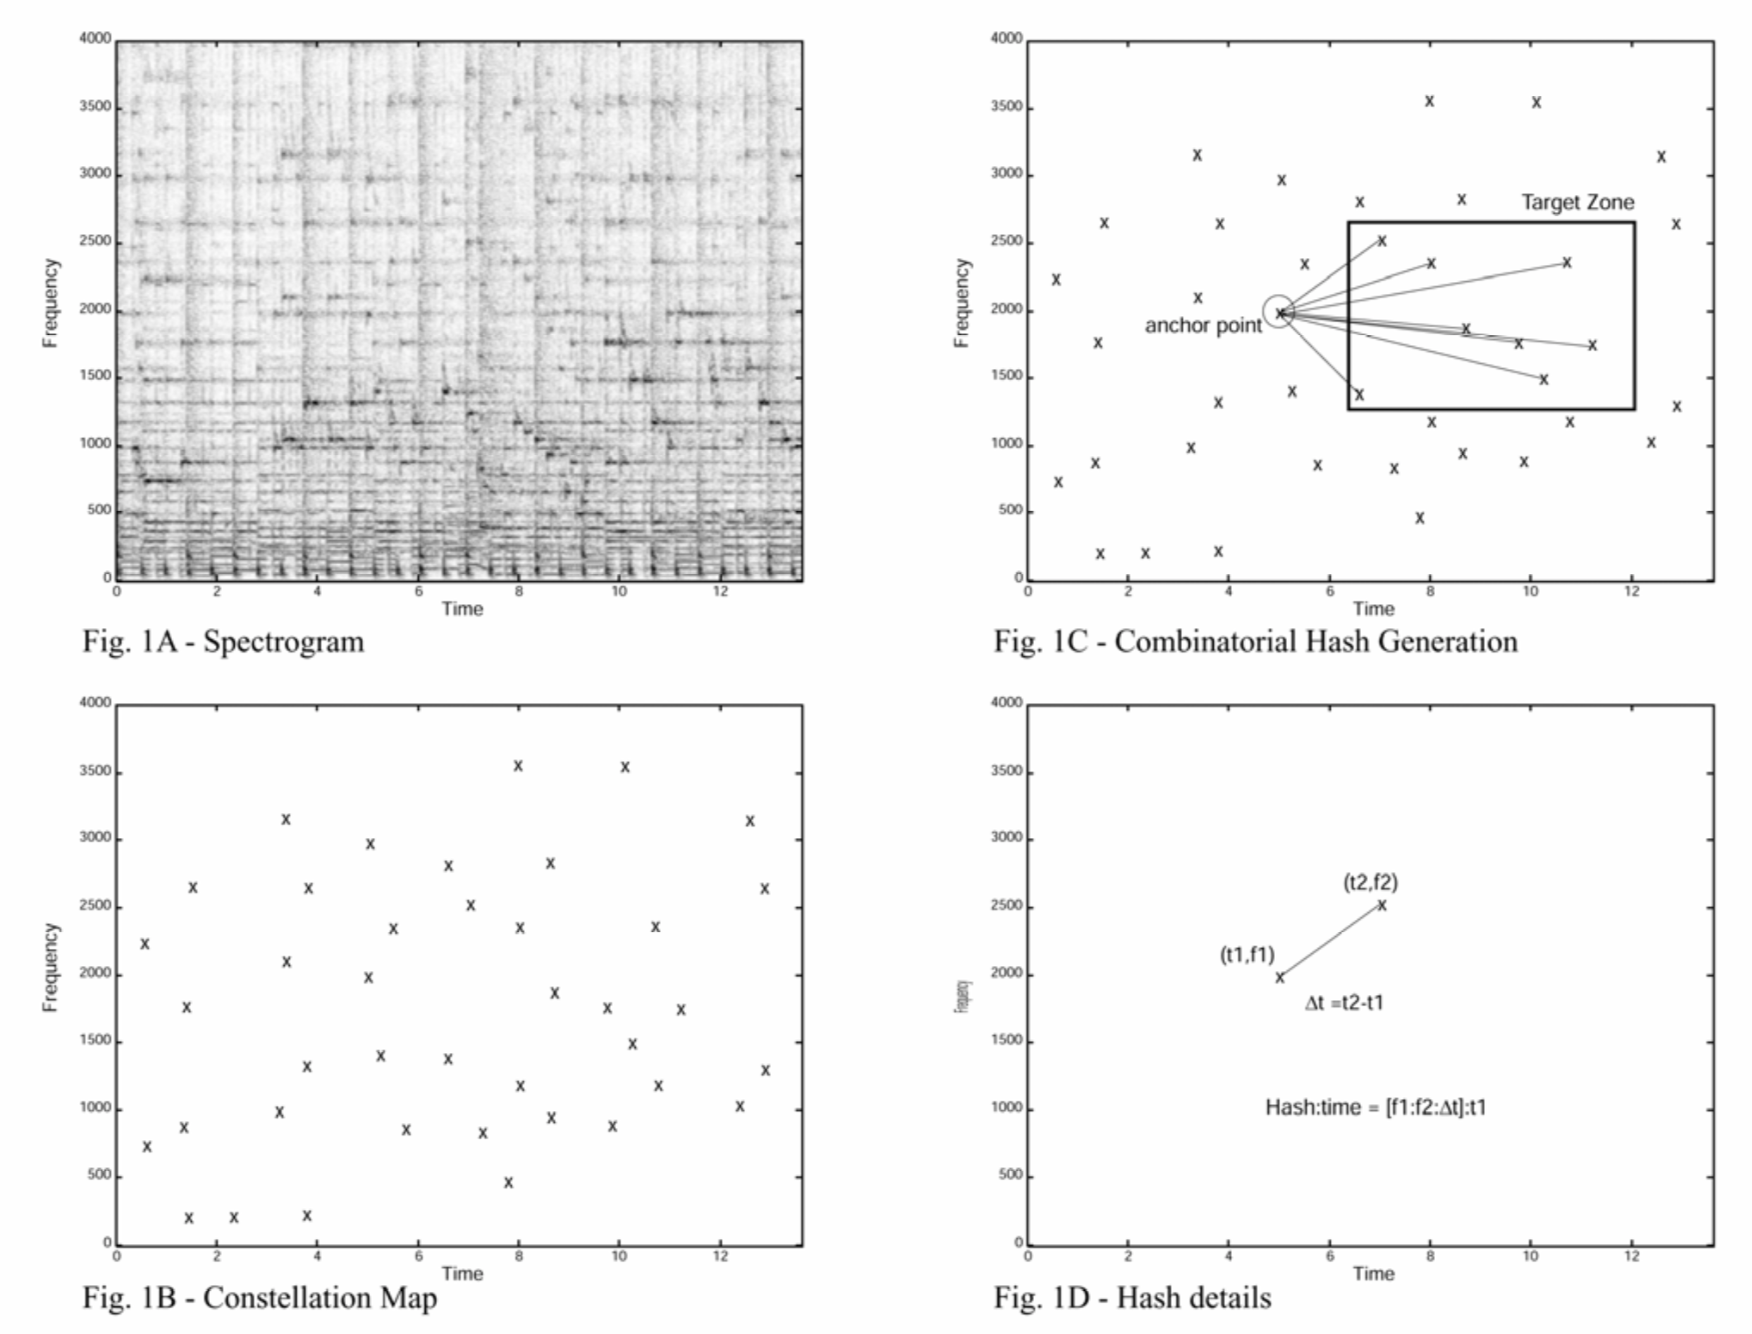

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).

Here's what mine looks like:


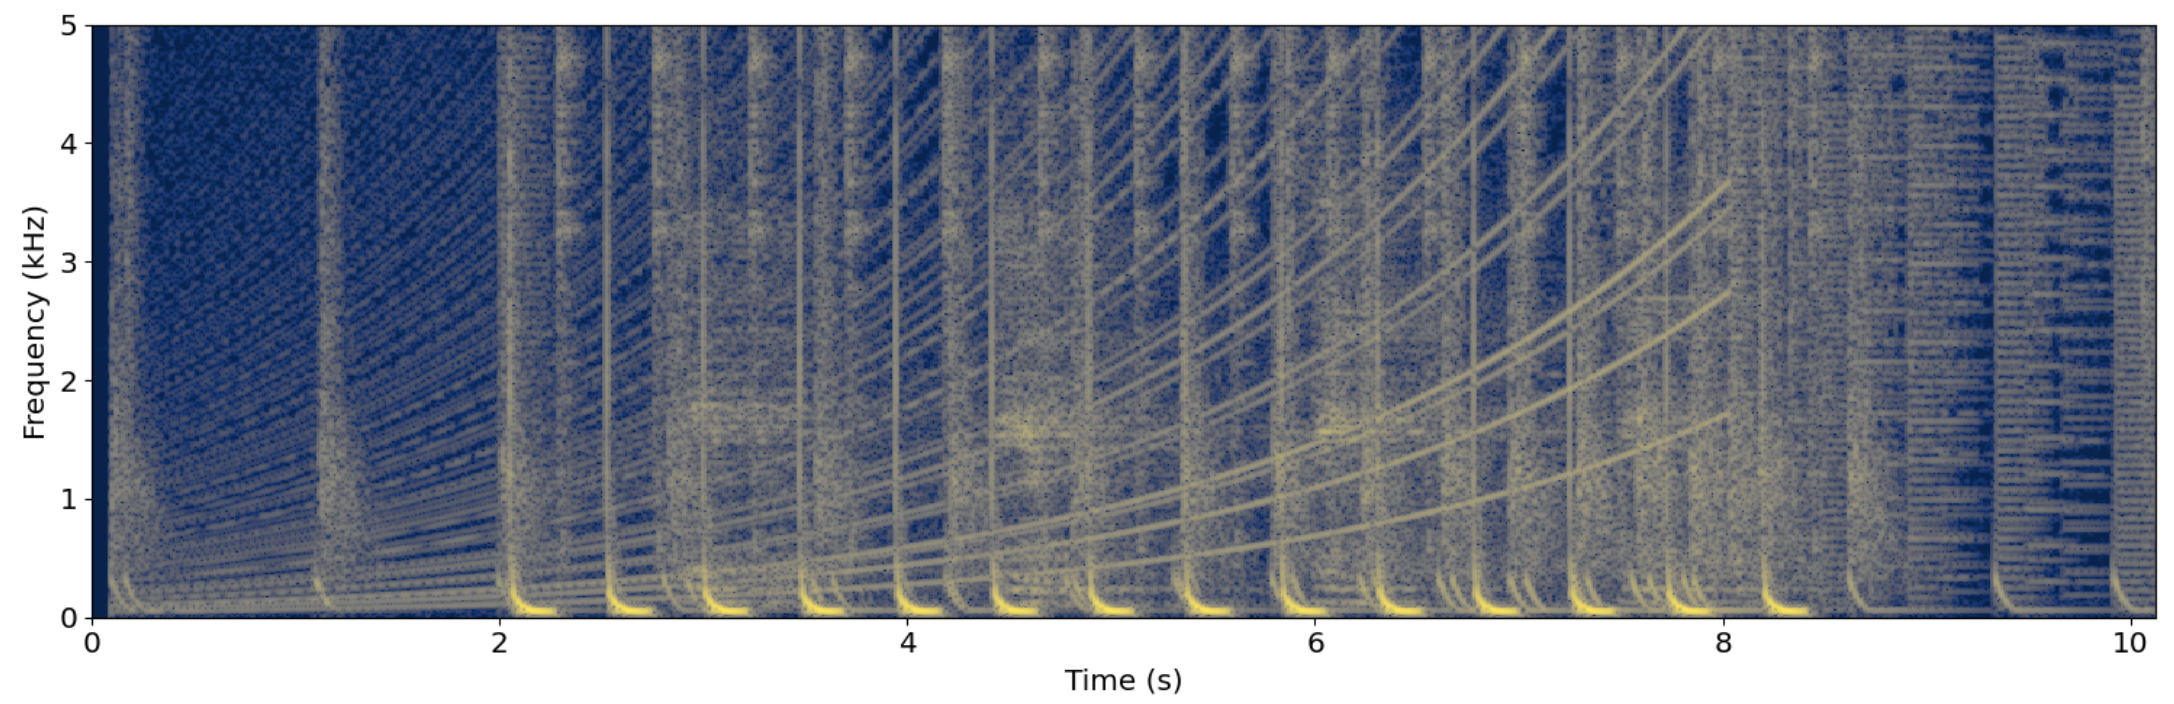

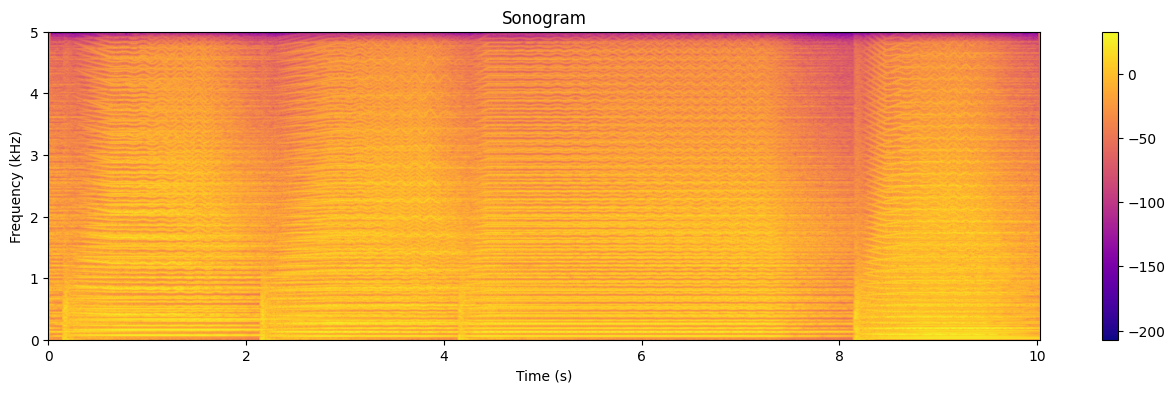

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load('./queries/Q1.wav') 

n_fft=int(4 * sr * 0.05)
hop_length=int(sr * 0.01)
win_length=int(sr * 0.05)

stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann', center=True)

stft_db = 20 * np.log10(np.abs(stft))

plt.figure(figsize=(16, 4))
plt.imshow(stft_db, origin='lower', extent=[0, len(y) / sr, 0, 5], aspect='auto', cmap='plasma') 
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('Sonogram')
plt.colorbar()
plt.show()

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [3]:
import numpy as np

def find_anchors(stft_db,hop_length,sr):

    time_bins_per_segment = int(0.1 / (hop_length/ sr))  # 每100ms的时间窗对应的列数
    freq_bins_per_segment = stft_db.shape[0] // 25  # 每个频带的行数

# Iterate over time-frequency bins
    anchors = []
    for t in range(0, stft_db.shape[1], time_bins_per_segment):
        for f in range(0, stft_db.shape[0], freq_bins_per_segment):
        # 当前区域
            t_end = min(t + time_bins_per_segment, stft_db.shape[1])
            f_end = min(f + freq_bins_per_segment, stft_db.shape[0])
            region = stft_db[f:f_end, t:t_end]
        
            max_idx = np.unravel_index(np.argmax(region, axis=None), region.shape) #将展平的索引转换回 2D 矩阵中的行列索引
            max_dB = region[max_idx]

        # 计算最大值对应的全局时间和频率坐标
            max_time = (t + max_idx[1]) * hop_length / sr  # 转换为秒
            max_freq = (f + max_idx[0]) * sr / n_fft  # 转换为Hz

            anchors.append((max_time, max_freq, max_dB))
    return anchors
# 打印找到的锚点
anchors = find_anchors(stft_db,hop_length,sr)
for anchor in anchors:
    print(f"Time: {anchor[0]:.3f} s, Frequency: {anchor[1]:.3f} Hz, dB: {anchor[2]:.2f} dB")

Time: 0.050 s, Frequency: 290.000 Hz, dB: 15.29 dB
Time: 0.060 s, Frequency: 625.000 Hz, dB: 8.15 dB
Time: 0.060 s, Frequency: 885.000 Hz, dB: 4.30 dB
Time: 0.020 s, Frequency: 1475.000 Hz, dB: 7.51 dB
Time: 0.010 s, Frequency: 1770.000 Hz, dB: 2.18 dB
Time: 0.070 s, Frequency: 2245.000 Hz, dB: 0.48 dB
Time: 0.060 s, Frequency: 2665.000 Hz, dB: 5.85 dB
Time: 0.070 s, Frequency: 3080.000 Hz, dB: 4.83 dB
Time: 0.030 s, Frequency: 3785.000 Hz, dB: -0.71 dB
Time: 0.010 s, Frequency: 4355.000 Hz, dB: -4.19 dB
Time: 0.010 s, Frequency: 4465.000 Hz, dB: -2.32 dB
Time: 0.040 s, Frequency: 5065.000 Hz, dB: -7.94 dB
Time: 0.040 s, Frequency: 5635.000 Hz, dB: -7.85 dB
Time: 0.090 s, Frequency: 6155.000 Hz, dB: -10.16 dB
Time: 0.010 s, Frequency: 6175.000 Hz, dB: -8.55 dB
Time: 0.050 s, Frequency: 6815.000 Hz, dB: -19.83 dB
Time: 0.010 s, Frequency: 7170.000 Hz, dB: -20.01 dB
Time: 0.010 s, Frequency: 7570.000 Hz, dB: -18.88 dB
Time: 0.060 s, Frequency: 7980.000 Hz, dB: -14.59 dB
Time: 0.050 s, Fr

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x". 


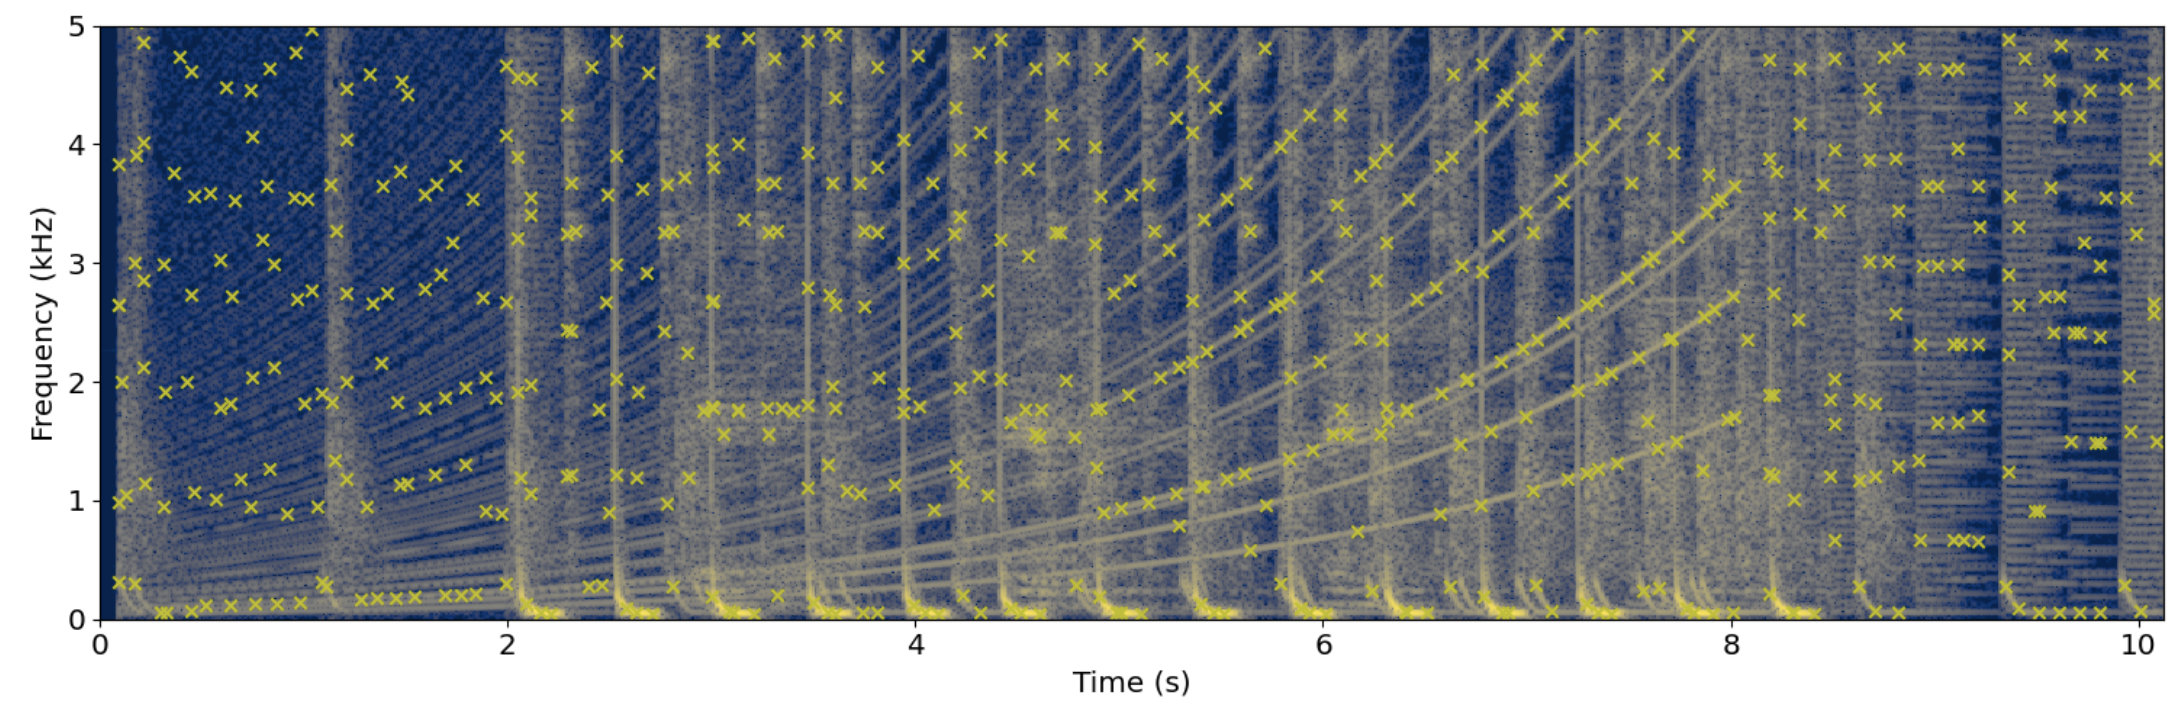

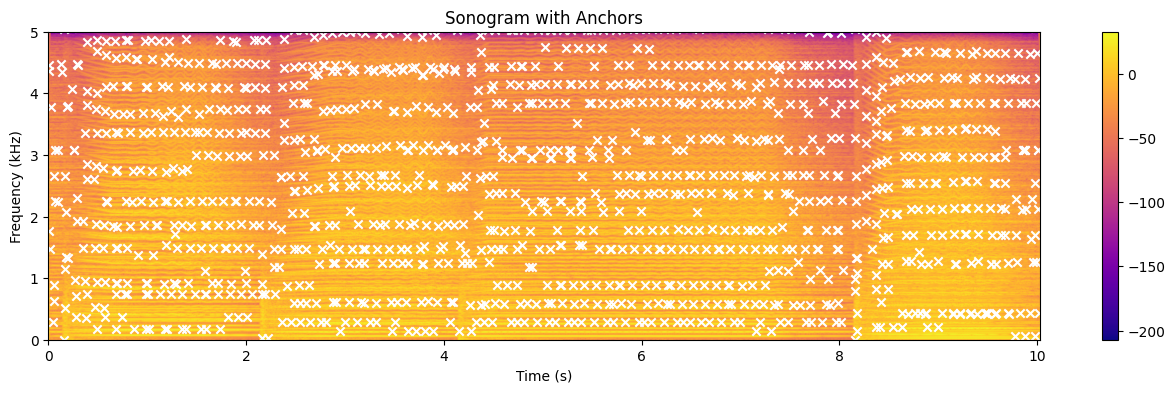

In [4]:
# 显示声谱图和锚点
plt.figure(figsize=(16, 4))
plt.imshow(stft_db, origin='lower', extent=[0, len(y) / sr, 0, 5], aspect='auto', cmap='plasma') 
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('Sonogram with Anchors')
plt.colorbar()

# 在声谱图上标记锚点
for anchor in anchors:
    plt.scatter(anchor[0], anchor[1] / 1000, color='white', marker='x')

plt.ylim(0, 5)

plt.show()


Here we simplify the description of the sonogram. Before we using the anchor locating algorithm, the samples included information about amplitude, frequency, and time. However, after we using anchors to represent the sonogram, we dropped the amplitude parameter, thus changing the “three-dimensional” samples into “two-dimensional” samples. Now we have only 2500 points, which means that the complexity of the initial problem is reduced.

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [5]:
import numpy as np
class hash:
    def __init__(self, f1, f2, t1,t2):
        self.f1 = f1          # Frequency anchor 1
        self.f2 = f2          # Frequency anchor 2
        self.d_t = t2 - t1 

def get_hash(anchors):
    fingerprints = []

    freq_lower_factor = 2**(-0.5)
    freq_upper_factor = 2**(0.5)

# 遍历每个锚点
    for i, (t1, f1, _) in enumerate(anchors):
        t_start = t1 + 0.1 
        t_end = t1 + 0.1 + 0.5
        f_lower = f1 * freq_lower_factor
        f_upper = f1 * freq_upper_factor

        for j in range(i + 1, len(anchors)):
            t2, f2, _ = anchors[j]
        
            # check
            if t_start <= t2 <= t_end and f_lower <= f2 <= f_upper:
                delta_t = t2 - t1           
                # build hash (f1, f2, Δt)
                hash_value = hash(f1, f2, t1,t2)
                fingerprints.append({t1:hash_value})
    return fingerprints
        
# example
fingerprints = get_hash(anchors)
#for i in fingerprints[:10]:
#    print(i.keys(),i.values().f1)
    #print(i)


# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this:



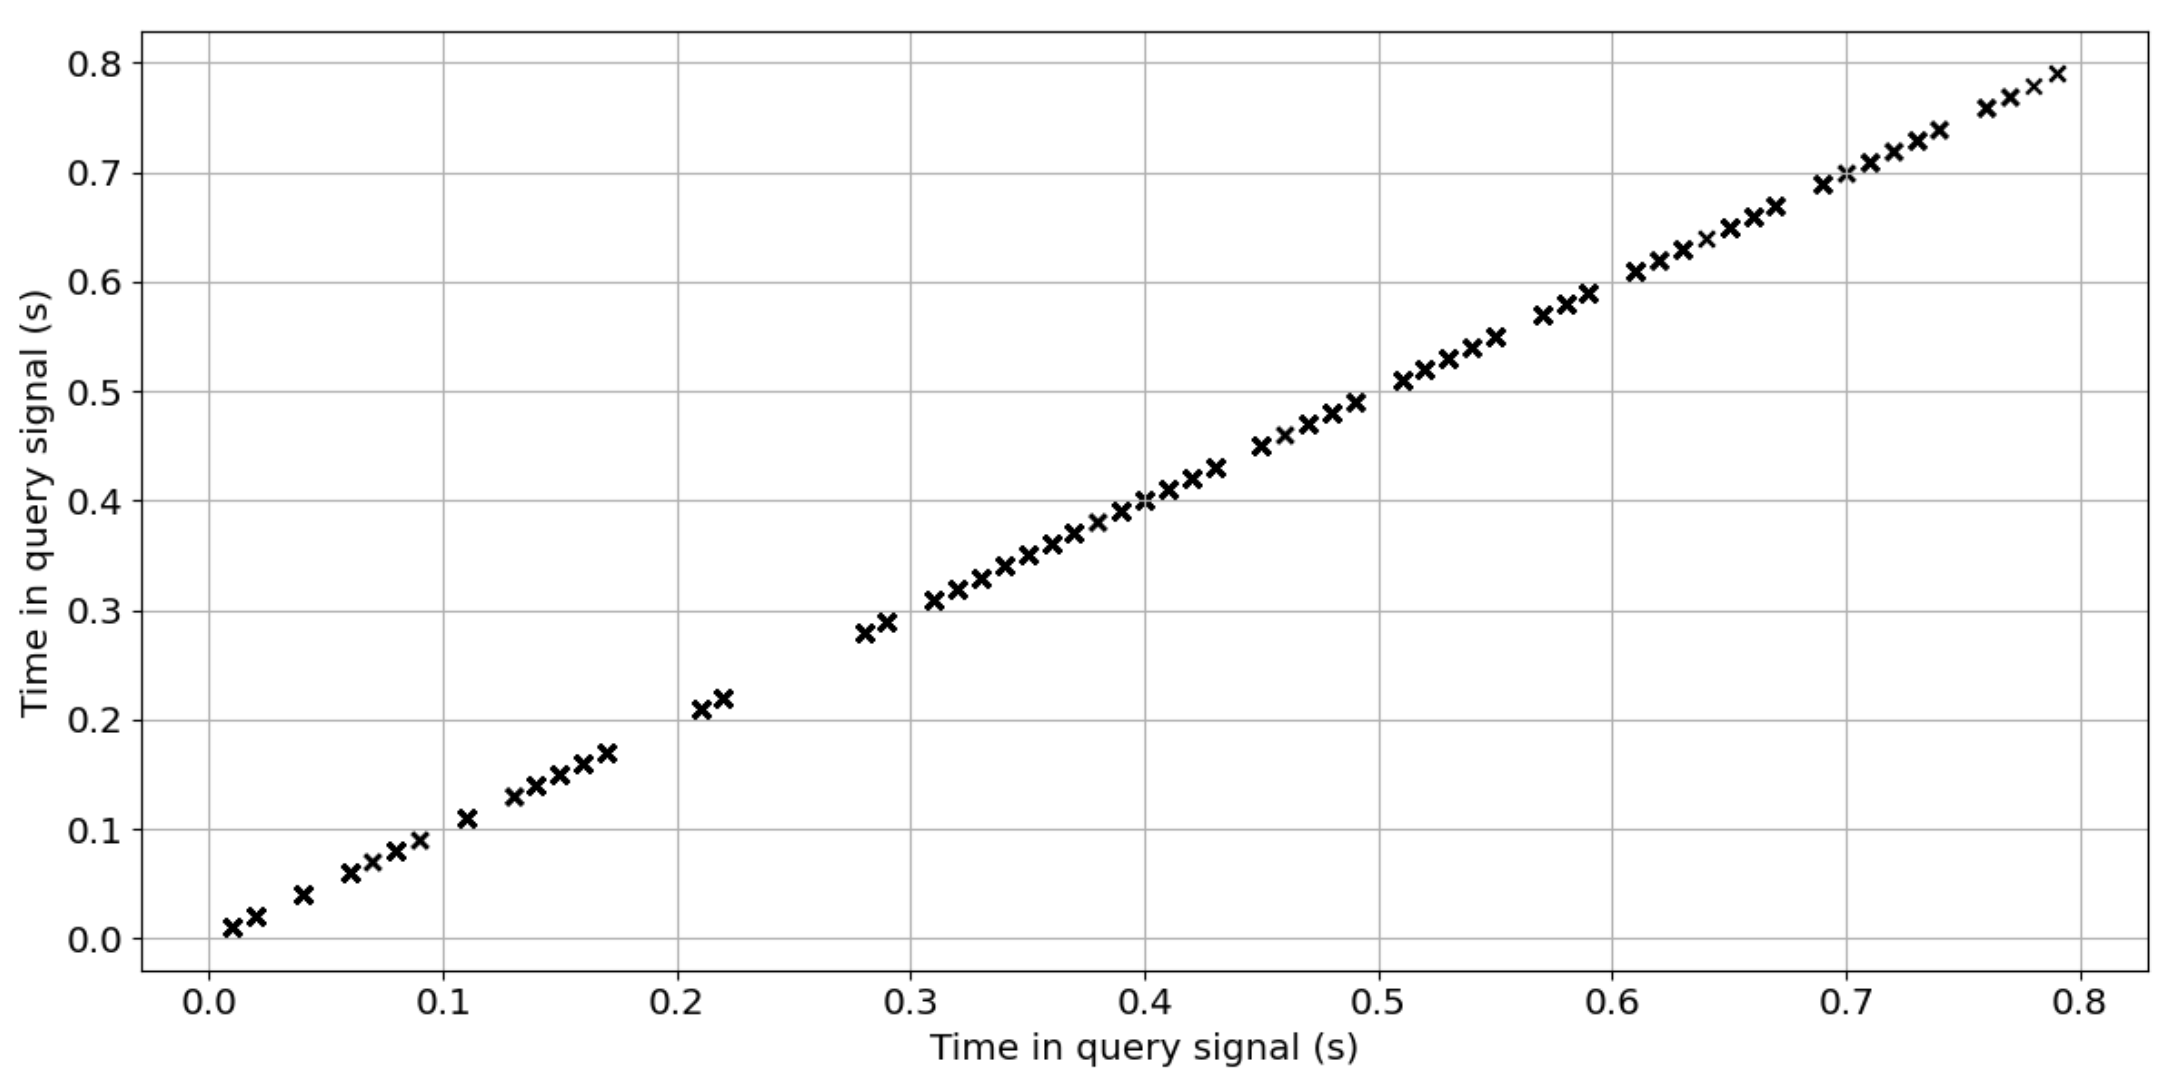

In [6]:
y, sr = librosa.load('./queries/Q1.wav')
num_samples = sr * 1  # 1秒的数据，采样率sr表示每秒的样本数
offset = sr * 0
# 截取前一秒的音频数据
y1 = y[offset:num_samples+offset]

n_fft=int(4 * sr * 0.05)
hop_length=int(sr * 0.01)
win_length=int(sr * 0.05)

q_stft = librosa.stft(y1, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann', center=True)

q_stft_db = 20 * np.log10(np.abs(q_stft))

q_anchors = find_anchors(q_stft_db,hop_length,sr)
q_fingerprints = get_hash(q_anchors)
print(len(anchors))

2626


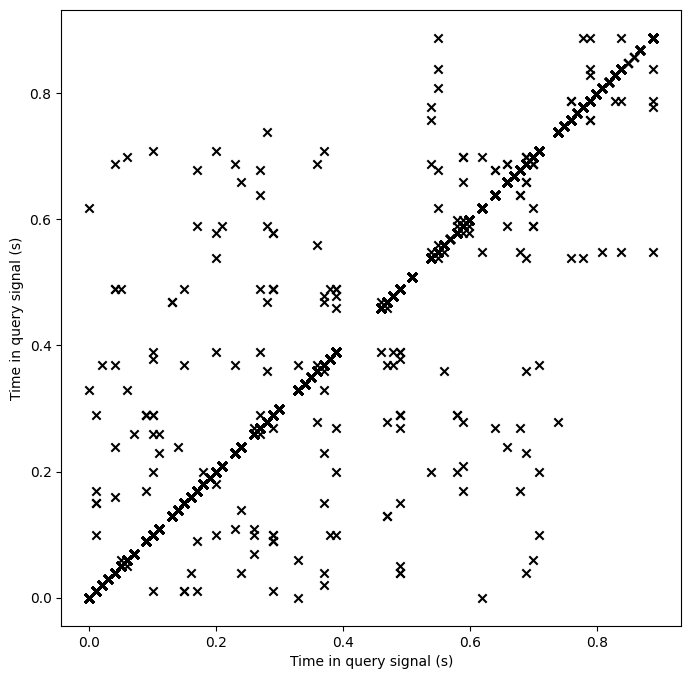

In [7]:
def fingerprint_comparing(F1, F2):
    F1_match = []
    F2_match = []
    count = 0
    for i in F1:
        count+=1
        #update_progress(count / len(F1))
      #print(str(count)+'/'+str(len(F1)))
        F1_time = list(i.keys())[0]
        F1_f1 = i[F1_time].f1
        F1_f2 = i[F1_time].f2
        F1_At1t2 = i[F1_time].d_t
        for j in F2:
            F2_time = list(j.keys())[0]
            F2_f1 = j[F2_time].f1
            F2_f2 = j[F2_time].f2
            F2_At1t2 = j[F2_time].d_t
            d = abs((F1_f1-F2_f1)+(F1_f2-F2_f2)+(F1_At1t2-F2_At1t2))
            if d == 0:
                F1_match.append(F1_time)
                F2_match.append(F2_time)
    return F1_match, F2_match

F1_match, F2_match = fingerprint_comparing(q_fingerprints, q_fingerprints)

params = {'figure.figsize': (8,8)}
plt.rcParams.update(params)
plt.scatter(F1_match, F2_match,c='black', marker="x")
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

As shown in the figure, we get several matches between the two fingerprints. The images are symmetrical, and most of the matches are located along the diagonal of the image. This is because the two sets of fingerprints we used are identical. Conversely, when matches appear on the diagonal, we can say that the two music segments are very similar.

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

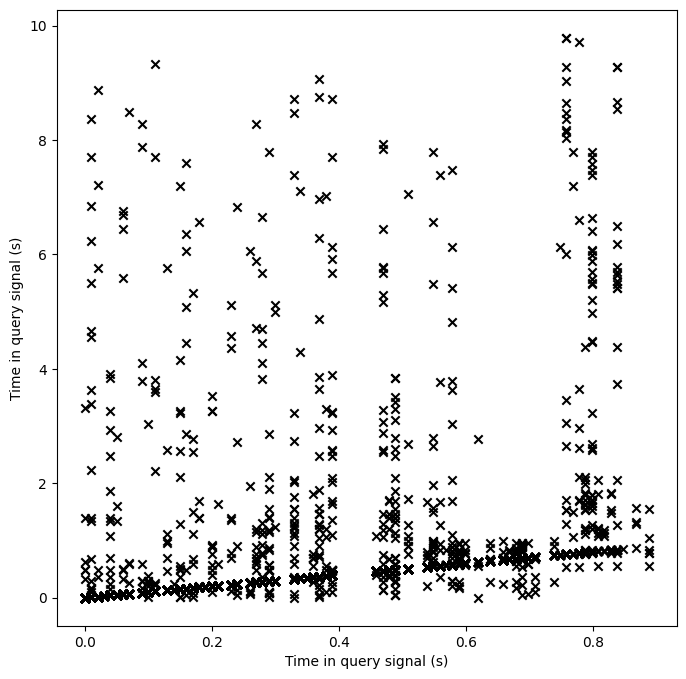

In [8]:
F1_match, F2_match = fingerprint_comparing(q_fingerprints, fingerprints)

params = {'figure.figsize': (8,8)}
plt.rcParams.update(params)
plt.scatter(F1_match, F2_match,c='black', marker="x")
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

The two sets of fingerprints correspond to Q1 and a one-second segment of Q1, respectively. Therefore, we see that the line in the figure is compressed within one second, and the slope has decreased from 1 in the previous question.

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the last parts.

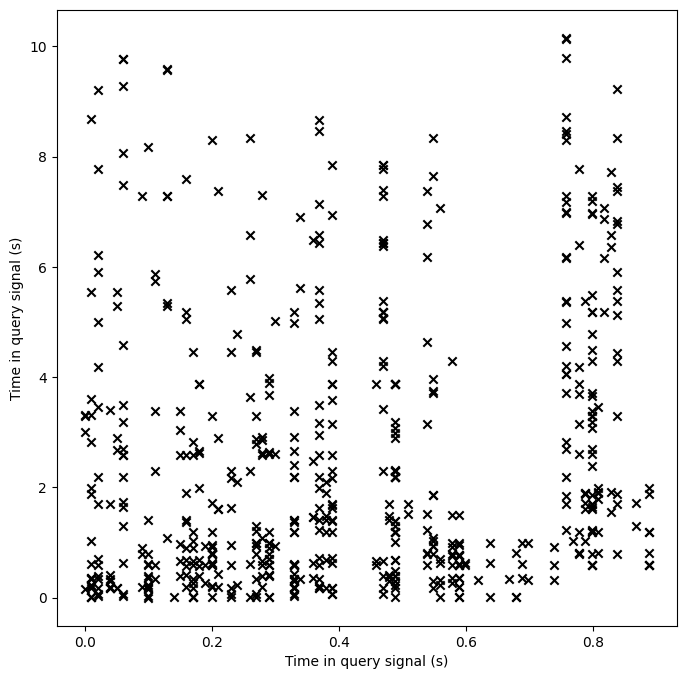

In [9]:
y, sr = librosa.load('./queries/Q3.wav') 

n_fft=int(4 * sr * 0.05)
hop_length=int(sr * 0.01)
win_length=int(sr * 0.05)

d_stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann', center=True)
d_stft_db = 20 * np.log10(np.abs(d_stft))

d_anchors = find_anchors(d_stft_db,hop_length,sr)
d_fingerprints = get_hash(d_anchors)

F1_match, F2_match = fingerprint_comparing(q_fingerprints, d_fingerprints)

params = {'figure.figsize': (8,8)}
plt.rcParams.update(params)
plt.scatter(F1_match, F2_match,c='black', marker="x")
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

We have not a single matching point! This is NOT the document.

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.